In [1]:
# imports libraries
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import math
import csv
import IPython

%matplotlib inline 

# Grabs the preprocessing and automatic_sync files
sys.path.append(os.path.join(os.pardir,'pythonCode'))
import preprocessing as pp
import automatic_sync as autoS

In [25]:
# Determines which cameras will be selected (['Bents'],['Camera Location'],['Motion #'])
filt = (None,['NL','SL'],['18']) # Selects the bent 1 camera used during motion 18

# now reads in the datafile from the raw data folder
rawDataPath = os.path.join(os.pardir,'rawData')
files = glob.glob(os.path.join(rawDataPath, '*.wav'))
names = []
        
for name in files:
    fileName = os.path.basename(name).split(".")[0]
    names.append(fileName)

# Applies filter to camera names and returns only selected subset names
audioFiles = pp.getKeys(names,filt);
# Reads the .wav files from the list generted by getKeys
(names,rawDataset) = pp.readWAV(rawDataPath,audioFiles);

Opening GP_B1_NL_18 ...
Opening GP_B1_SL_18 ...
Opening GP_B2_SL_18 ...
Opening GP_B3_NL_18 ...
Opening GP_B3_SL_18 ...


In [26]:
final_offsets, syncData, cData = sync_dataset(rawDataset,names[0],names,mask=[0.7,1])

dict_values([0, 0, 0, 0, 0])


In [111]:
this_range = range(1684000,1696000)

In [112]:
IPython.display.Audio(syncData[names[1]][this_range,0].T,rate=12000)

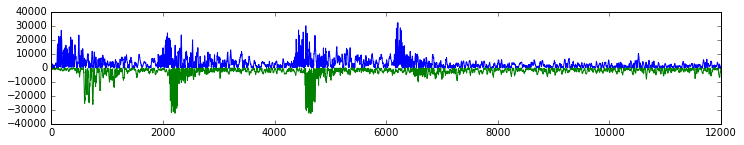

In [113]:
fig = plt.figure(figsize=(12,2))
plt.plot(abs(syncData[names[1]][this_range,0]))
plt.plot(-abs(syncData[names[0]][this_range,0]))
plt.show()
fig.tight_layout() 

In [96]:
IPython.display.Audio(syncData[names[0]][this_range,0].T,rate=12000)

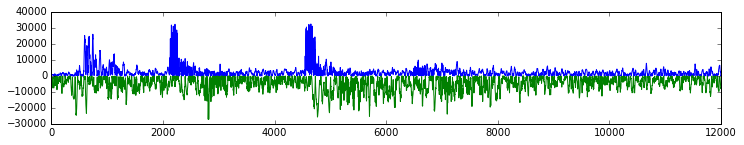

In [114]:
fig = plt.figure(figsize=(12,2))
plt.plot(abs(syncData[names[0]][this_range,0]))
plt.plot(-abs(syncData[names[2]][this_range,0]))
plt.show()
fig.tight_layout() 

In [98]:
IPython.display.Audio(syncData[names[2]][this_range,0].T,rate=12000)

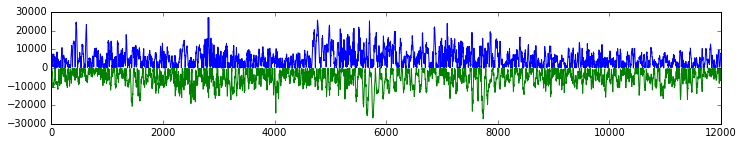

In [99]:
fig = plt.figure(figsize=(12,2))
plt.plot(abs(syncData[names[2]][this_range,0]))
plt.plot(-abs(syncData[names[3]][this_range,0]))
plt.show()
fig.tight_layout() 

In [100]:
IPython.display.Audio(syncData[names[3]][this_range,0].T,rate=12000)

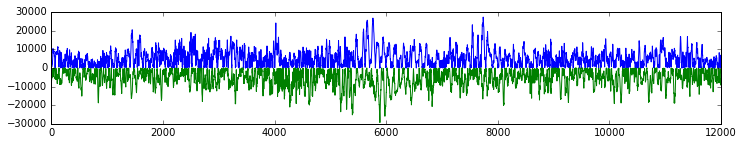

In [101]:
fig = plt.figure(figsize=(12,2))
plt.plot(abs(syncData[names[3]][this_range,0]))
plt.plot(-abs(syncData[names[4]][this_range,0]))
plt.show()
fig.tight_layout() 

In [102]:
IPython.display.Audio(syncData[names[4]][this_range,0].T,rate=12000)

In [3]:
def sync_dataset(dataset,indexName,names,max_iter = 2,mask=[0,1]):
    '''
    offsets, sDataset = sync_dataset(cDataset,names,max_iter = 2). Syncs the input dataset (dictionary) 
    with corresponding keys (names), recursively determines relative offsets using the cross 
    correlation. 
    Inputs:
        cDataset (dict) - dictionary with raw audio data, each key corresponds to an (Ni,2) array of 1D signals.
        names (list) - keys to the dictionary (data will be synced to names[0])
        max_iter (optional) - maximum number of iterations to be performed.
        mask (optional) - range of values to consider in syncing. Relative values ranging from [0,1], list size (2,)
    Outputs:
        sDataset (dict) - synced dataset (each entry has the same length)
        final_offsets (dict) - final signal offset values
        
    '''
    
    # copies original dataset to work on the copy
    origDataset = dataset.copy()
    cDataset = dataset.copy()
    
    # initializes variables
    iter_count = 0
    final_offsets ={}
    mask_offset = 0
    start_index ={}
    
    # apllies the mask to the indexName values in the dataset
    for name in names:
        Npoints = len(cDataset[name][:,0])
        startInd = int(np.floor(Npoints*mask[0]))
        endInd = int(np.ceil(Npoints*mask[1]))
        cDataset[name] = cDataset[name][startInd:endInd,:]
        start_index[name] = startInd
        final_offsets[name] = 0
        
    # initializes final offsets
    #mask_offset = startInd
    #print(mask_offset)
        
    offsets =  autoS.find_offset(cDataset,indexName,[k  for k in names if k != indexName])
    
    if abs(sum(offsets.values())) == 0:
        final_offsets = offsets
    else:
        # syncs the masked dataset
        while abs(sum(offsets.values())) > 0 and iter_count < max_iter:

            #print(offsets)
            endInd = np.Inf
            startInd = 0

            for name in names:
                if offsets[name] > startInd:
                    startInd = offsets[name]
                if len(cDataset[name][:,0]) < endInd:
                    endInd = len(cDataset[name][:,0])

            for name in names:
                cDataset[name] = cDataset[name][startInd-offsets[name]:endInd-offsets[name],:]
                final_offsets[name] = final_offsets[name] + startInd-offsets[name]

            offsets = autoS.find_offset(cDataset,indexName,[k  for k in names if k != indexName])
            iter_count += 1
        
        print(offsets.values())
        assert sum(offsets.values()) == 0, print(offsets)
    
        # Modifies the original dataset based on the start location identified through syncing
        #
        #            offset    start Ind
        # |----------------|--|--------------| signal 1
        #                  |
        # |------- L1 -----|------ L2 -------|
        #                  |
        #                  |     start Ind
        #    |-------------|----|-----------------|  signal 2
        #                  |
        #    |----- L1 ----|--------- L2 ---------|
        #                  |
        #                  |
        #
        #    |------------------------------| final signal length
        #

        Lend = np.Inf
        Lstart = np.Inf
        Lref = start_index[indexName]+final_offsets[indexName]

        for name in names:
            L1 = start_index[name]+final_offsets[name]
            L2 = len(origDataset[name][:,0]) - L1

            Lend= min([Lend,L2])
            Lstart = min([Lstart,L1])
            


        for name in names:
            L1 = start_index[name]+final_offsets[name]
            this_range = range(L1-Lstart,L1+Lend)
            origDataset[name] = origDataset[name][this_range,:]
            final_offsets[name] = Lref-L1
    
    return final_offsets, origDataset, cDataset